In [10]:
# https://github.com/franchyze923/Code_From_Tutorials/blob/master/Strava_Api/strava_api.py
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import numpy as np
import matplotlib.pyplot as plt
import polyline
import pandas as pd
from datetime import datetime, date
from matplotlib.dates import date2num, num2date
import ipywidgets as widgets
from matplotlib import animation
%matplotlib widget

### Download data using API

In [2]:
auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': open('client_id', 'r').read(),
    'client_secret': open('client_secret', 'r').read(),
    'refresh_token': open('refresh_token', 'r').read(),
    'grant_type': "refresh_token",
    'f': 'json'
}

res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
header = {'Authorization': 'Bearer ' + access_token}

param = {'per_page': 200, 'page': 3}
my_dataset = requests.get(activites_url, headers=header, params=param).json()

# Loop through pages
my_dataset = []
page = 1
len_page_data = 1
while len_page_data > 0:
    param = {'per_page': 200, 'page': page}
    page_data = requests.get(activites_url, headers=header, params=param).json()
    len_page_data = len(page_data)
    my_dataset.extend(page_data)
    page += 1

print(len(my_dataset))

343


### Organise data

In [3]:
# Convert to dataframe
activities = pd.json_normalize(my_dataset)

# Keep the interesting columns
activities = activities[['name', 'distance', 'moving_time', 'elapsed_time', 'total_elevation_gain', 'type', 'start_date_local',
                           'average_speed', 'elev_high', 'elev_low',  'map.summary_polyline']]

# Convert dates/times
activities['start_date_local'] = pd.to_datetime(activities['start_date_local'])
activities['start_time'] = activities['start_date_local'].dt.time
activities['start_date_local'] = activities['start_date_local'].dt.date
activities.sort_values(by='start_date_local', ascending=True, inplace=True, ignore_index=True)
# activities.head()
len(activities)

343

### Filter London runs

In [4]:
lon_boundaries = [-0.36, 0.19]
lat_boundaries = [51.36, 51.60]
start_points = activities['map.summary_polyline'].apply(lambda x: polyline.decode(x)[0])
in_london = [(lon_boundaries[0] < x[1] < lon_boundaries[1]) * (lat_boundaries[0] < x[0] < lat_boundaries[1]) for x in start_points]
runs = (activities.type == 'Run')
activities_london_runs = activities[(runs * in_london).astype(bool)]
len(activities_london_runs)


195

### Plot runs

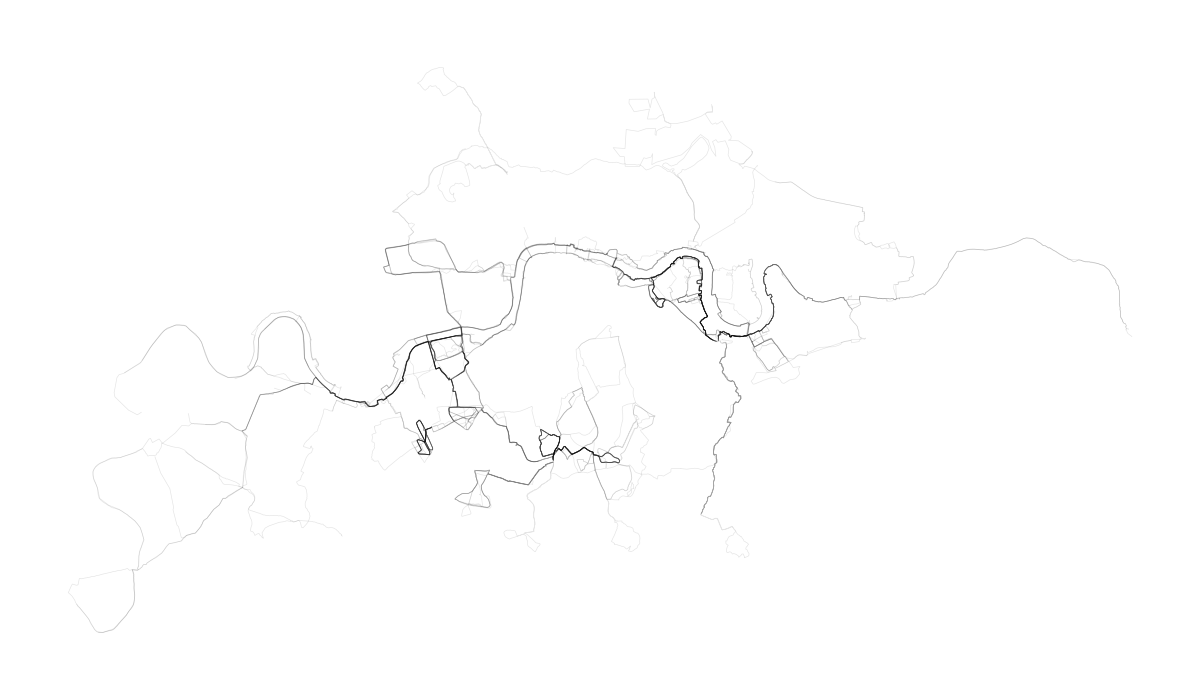

In [27]:
# Set up plot
fig, ax = plt.subplots()
ax.axis('off')
fig.set_size_inches(12,7)
fig.tight_layout()
ax.set_aspect('equal')

# Plot runs
for p in activities_london_runs['map.summary_polyline']:
    
    # Get coordinates
    coordinates = polyline.decode(p)
    longitudes = np.array([coordinate[1] for coordinate in coordinates])
    latitudes = np.array([coordinate[0] for coordinate in coordinates])

    # Convert to distances
    dist_lat = latitudes * 110.574
    dist_lon = 111.320 * np.cos(np.radians(latitudes)) * longitudes

    # Plot
    ax.plot(dist_lon, dist_lat, c='k', alpha=0.1, linewidth=0.5)


### Slider plot (date)

In [25]:
# # Set up plot
# fig, ax = plt.subplots()
# ax.axis('off')
# fig.set_size_inches(12,7)
# fig.tight_layout()
# ax.set_aspect('equal')

# # Plot runs
# for p in activities_london_runs['map.summary_polyline']:
    
#     # Get coordinates
#     coordinates = polyline.decode(p)
#     longitudes = np.array([coordinate[1] for coordinate in coordinates])
#     latitudes = np.array([coordinate[0] for coordinate in coordinates])

#     # Convert to distances
#     dist_lat = latitudes * 110.574
#     dist_lon = 111.320 * np.cos(np.radians(latitudes)) * longitudes

#     # Plot
#     ax.plot(dist_lon, dist_lat, 'r-', alpha=0.05)

# # Animate
# start = date2num(activities.iloc[0].start_date_local) - 1
# @widgets.interact(slider_date=(start, date2num(date.today()), 1))
# def update(slider_date=start):
#     for d, l in zip(date2num(activities.start_date_local), ax.lines):
#         if d <= slider_date:
#             l.set_visible(True)
#         else:
#             l.set_visible(False)
    

### Timeline